# LQ Approximation with `QuantEcon.jl` and `ContinuousDPs`

In [1]:
using QuantEcon
using ContinuousDPs
using Plots
import QuantEcon.ScalarOrArray

We consider a dynamic maximization problem with

* reward function $f(s, x)$,
* state transition function $g(s, x)$, and
* discount rate $\delta$,

where $s$ and $x$ are the state and the control variables, respectively
(we follow Miranda-Fackler in notation).

Let $(s^*, x^*)$ denote the steady state state-control pair,
and write
$f^* = f(s^*, x^*)$, $f_i^* = f_i(s^*, x^*)$, $f_{ij}^* = f_{ij}(s^*, x^*)$,
$g^* = g(s^*, x^*)$, and $g_i^* = g_i(s^*, x^*)$ for $i, j = s, x$.

First-order expansion of $g$ around $(s^*, x^*)$:
$$
\begin{eqnarray*}
g\left(s,x\right) & \approx & \underbrace{g^{*}}_{n\times1}+\underbrace{g_{s}^{*}}_{n\times n}\left(s-s^{*}\right)+\underbrace{g_{x}^{*}}_{n\times m}\left(x-x^{*}\right)\\
\left[\begin{array}{c}
1\\
g\left(s,x\right)
\end{array}\right] & \approx & A\left(\begin{array}{c}
1\\
s
\end{array}\right)+Bx
\end{eqnarray*}
$$
where

\begin{eqnarray*}
A & = & \left[\begin{array}{cc}
1 & 0\\
g^{*}-Dg^{*}z^{*} & g_{s}^{*}
\end{array}\right]\\
B & = & \left[\begin{array}{c}
0\\
g_{x}^{*}
\end{array}\right]
\end{eqnarray*}

with $z^* = (s^*, x^*)^{\mathrm{T}}$ and $Dg^* = (g_s^*, g_x^*)$.

Second-order expansion of $f$ around $(s^*, x^*)$:

\begin{eqnarray*}
f\left(s,x,e\right) & \approx & \underbrace{f^{*}}_{1\times1}+\underbrace{f_{s}^{*}}_{1\times n}\left(s-s^{*}\right)+\underbrace{f_{x}^{*}}_{1\times m}\left(x-x^{*}\right)+0.5\left(s-s^{*}\right)'\underbrace{f_{ss}^{*}}_{n\times n}\left(s-s^{*}\right)\\
 &  & +\left(s-s^{*}\right)'\underbrace{f_{sx}^{*}}_{n\times m}\left(x-x^{*}\right)+0.5\left(x-x^{*}\right)'\underbrace{f_{xx}^{*}}_{m\times m}\left(x-x^{*}\right)\\
 & = & -\left(\left(\begin{array}{cc}
1 & s'\end{array}\right)R\left(\begin{array}{c}
1\\
s
\end{array}\right)+2x'N\left(\begin{array}{c}
1\\
s
\end{array}\right)+x'Qx\right)
\end{eqnarray*}

where

\begin{eqnarray*}
R & = & -\left[\begin{array}{cc}
f^{*}-\left(Df^{*}\right)'z^{*}+0.5\left(z^{*}\right)'D^{2}f^{*}z^{*} & 0.5\left(f_{s}^{*}-\left(\left(s^{*}\right)'f_{ss}^{*}+\left(f_{sx}^{*}x^{*}\right)'\right)\right)\\
0.5\left(\left(f_{s}^{*}\right)'-\left(f_{ss}^{*}s^{*}+f_{sx}^{*}x^{*}\right)\right) & 0.5f_{ss}^{*}
\end{array}\right]\\
N & = & -0.5\left[\begin{array}{cc}
\left(\left(f_{x}^{*}\right)'-\left(\left(f_{sx}^{*}\right)'s^{*}+f_{xx}^{*}x^{*}\right)\right) & \left(f_{sx}^{*}\right)'\end{array}\right]\\
Q & = & -\begin{array}{c}
\left[0.5f_{xx}^{*}\right]\end{array}
\end{eqnarray*}

with $Df^{*}=\left[\begin{array}{cc}
f_{s}^{*} & f_{x}^{*}\end{array}\right]^\mathrm{T}$ and $D^{2}f^{*}=\left[\begin{array}{cc}
f_{ss}^{*} & f_{sx}^{*}\\
f_{xs}^{*} & f_{xx}^{*}
\end{array}\right]$

## Optimal Economic Growth

We consider the following optimal growth model from Miranda and Fackler, Section 9.7.1:

* $f(s, x) = \dfrac{(s - x)^{1-\alpha}}{1-\alpha}$,
* $g(s, x) = \gamma + x^{\beta}$.

In [2]:
alpha = 0.2
bet = 0.5
gamm = 0.9
discount = 0.9;

Function definitions:

In [3]:
f(s, x) = (s - x)^(1 - alpha) / (1 - alpha)
f_s(s, x) = (s - x)^(-alpha)
f_x(s, x) = -f_s(s, x)
f_ss(s, x) = -alpha * (s - x)^(-alpha - 1)
f_sx(s, x) = -f_ss(s, x)
f_xx(s, x) = f_ss(s, x)

g(s, x) = gamm * x + x^bet
g_s(s, x) = 0
g_x(s, x) = gamm + bet * x^(bet - 1);

Steady state:

In [4]:
x_star = ((discount * bet) / (1 - discount * gamm))^(1 / (1 - bet))
s_star = gamm * x_star + x_star^bet
s_star, x_star

(7.416897506925212, 5.6094182825484795)

`(s_star, x_star)` satisfies the Euler equations:

In [5]:
f_x(s_star, x_star) + discount * f_s(g(s_star, x_star), x_star) * g_x(s_star, x_star)

1.1102230246251565e-16

Construct $f^*$, $D f^*$, $D^2 f^*$, $g^*$, and $D g^*$:

In [6]:
f_star = f(s_star, x_star)
Df_star = [f_s(s_star, x_star), f_x(s_star, x_star)]
DDf_star = [f_ss(s_star, x_star) f_sx(s_star, x_star);
            f_sx(s_star, x_star) f_xx(s_star, x_star)]
g_star = g(s_star, x_star)
Dg_star = [g_s(s_star, x_star), g_x(s_star, x_star)];

### LQ Approximation

Generate an LQ instance that approximates our dynamic optimization problem:

In [7]:
lq = approx_lq(s_star, x_star, f_star, Df_star, DDf_star, g_star, Dg_star', discount)

LQ([0.04914869864113181;;], [-0.24085180775732676 -0.5330115101939921; -0.5330115101939921 0.04914869864113181], [1.0 0.0; 1.1842105263157894 0.0], [0.0; 1.1111111111111112;;], [0.0; 0.0;;], [0.5330115101939921 -0.04914869864113181], 0.9, nothing, [NaN NaN; NaN NaN], [NaN NaN; NaN NaN], 0.0, [0.0 0.0])

### Solution by `stationary_values(::LQ)`

Solve the LQ problem:

In [8]:
P, F, d = stationary_values(lq)

([-13.211795608258779 -0.4806293445369966; -0.4806293445369966 0.004914869864113194], [1.0657894736842055 -0.8999999999999997], 0.0)

The optimal value function (of the LQ minimization problem):

In [9]:
V(s) = [1, s]' * P * [1, s] + d

V (generic function with 1 method)

The value at $s^*$:

In [10]:
V(s_star)

-20.070983979777214

In [11]:
-f_star / (1 - lq.bet)

-20.070983979777242

The optimal policy function:

In [12]:
X(s) = - (F * [1, s])[1]

X (generic function with 1 method)

The optimal choice at $s^*$:

In [13]:
X(s_star)

5.609418282548483

In [14]:
x_star

5.6094182825484795

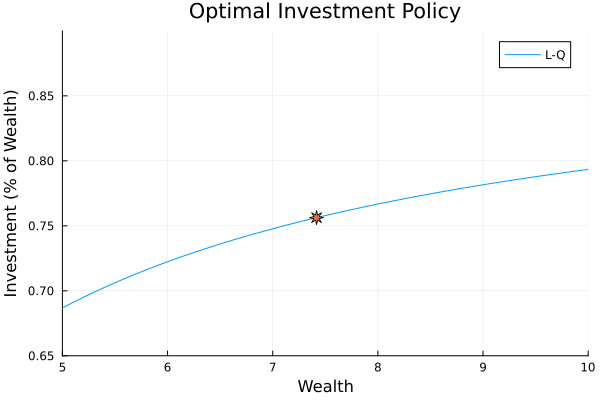

In [15]:
s_min, s_max = 5, 10
ss = range(s_min, stop=s_max, length=50)
title = "Optimal Investment Policy"
xlabel = "Wealth"
ylabel = "Investment (% of Wealth)"
plot(ss, X.(ss)./ss, xlims=(s_min, s_max), ylims=(0.65, 0.9),
     title=title, xlabel=xlabel, ylabel=ylabel, label="L-Q")
plot!([s_star], [x_star/s_star], m=(7,:star8), label="")

## Renewable Resource Management

Consider the renewable resource management model from Miranda and Fackler, Section 9.7.2:

* $f(s, x) = \dfrac{(s - x)^{1-\gamma}}{1-\gamma} - \kappa (s - x)$,
* $g(s, x) = \alpha x - 0.5 \beta x^2$.

In [16]:
alpha = 4.0
bet = 1.0
gamm = 0.5
kappa = 0.2
discount = 0.9;

In [17]:
f(s, x) = (s - x)^(1 - gamm) / (1 - gamm) - kappa * (s - x)
f_s(s, x) = (s - x)^(-gamm) - kappa
f_x(s, x) = -f_s(s, x)
f_ss(s, x) = -gamm * (s - x)^(-gamm - 1)
f_sx(s, x) = -f_ss(s, x)
f_xx(s, x) = f_ss(s, x)

g(s, x) = alpha * x - 0.5 * bet * x^2
g_s(s, x) = 0
g_x(s, x) = alpha - bet * x;

In [18]:
x_star = (discount * alpha - 1) / (discount * bet)
s_star = (alpha^2 - 1/discount^2) / (2 * bet)
s_star, x_star

(7.382716049382716, 2.888888888888889)

In [19]:
f_x(s_star, x_star) + discount * f_s(g(s_star, x_star), x_star) * g_x(s_star, x_star)

5.551115123125783e-17

In [20]:
f_star = f(s_star, x_star)
Df_star = [f_s(s_star, x_star), f_x(s_star, x_star)]
DDf_star = [f_ss(s_star, x_star) f_sx(s_star, x_star);
            f_sx(s_star, x_star) f_xx(s_star, x_star)]
g_star = g(s_star, x_star)
Dg_star = [g_s(s_star, x_star) g_x(s_star, x_star)];

In [21]:
lq = approx_lq(s_star, x_star, f_star, Df_star, DDf_star, g_star, Dg_star, discount)

LQ([0.0262431197105178;;], [-1.5898986690282433 -0.2537961323936474; -0.2537961323936474 0.0262431197105178], [1.0 0.0; 4.172839506172839 0.0], [0.0; 1.1111111111111112;;], [0.0; 0.0;;], [0.2537961323936474 -0.0262431197105178], 0.9, nothing, [NaN NaN; NaN NaN], [NaN NaN; NaN NaN], 0.0, [0.0 0.0])

In [22]:
P, F, d = stationary_values(lq)

([-31.26051474783933 -0.15523863836970273; -0.15523863836970286 0.0026243119710518074], [3.755555555555553 -0.899999999999999], 0.0)

In [23]:
V(s) = [1, s]' * P * [1, s] + d

V (generic function with 1 method)

In [24]:
V(s_star)

-33.40964351976545

In [25]:
-f_star / (1 - lq.bet)

-33.409643519765496

In [26]:
X(s) = - (F * [1, s])[1]

X (generic function with 1 method)

In [27]:
X(s_star)

2.8888888888888844

In [28]:
x_star

2.888888888888889

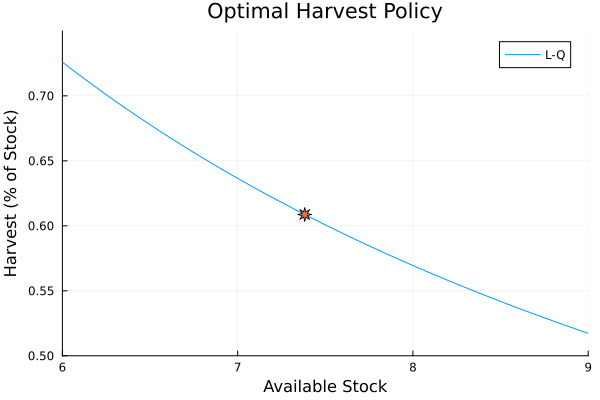

In [29]:
s_min, s_max = 6, 9
ss = range(s_min, stop=s_max, length=50)
harvest = ss - X.(ss)
h_star = s_star - x_star
title = "Optimal Harvest Policy"
xlabel = "Available Stock"
ylabel = "Harvest (% of Stock)"
plot(ss, harvest./ss, xlims=(s_min, s_max), ylims=(0.5, 0.75),
     title=title, xlabel=xlabel, ylabel=ylabel, label="L-Q")
plot!([s_star], [h_star/s_star], m=(7,:star8), label="")

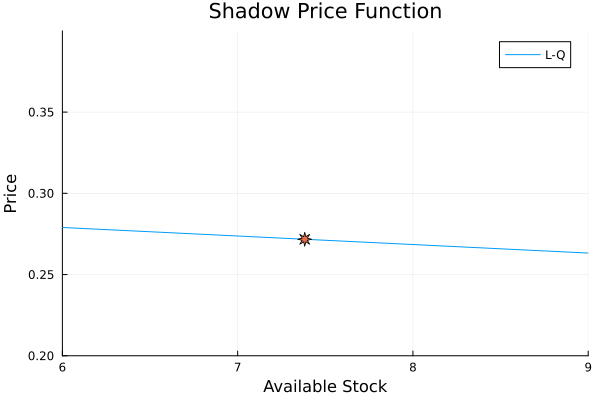

In [30]:
shadow_price(s) = -2 * (P * [1, s])[2]
title = "Shadow Price Function"
ylabel = "Price"
plot(ss, shadow_price.(ss), xlims=(s_min, s_max), ylims=(0.2, 0.4),
     title=title, xlabel=xlabel, ylabel=ylabel, label="L-Q")
plot!([s_star], [shadow_price(s_star)], m=(7,:star8), label="")